In [15]:
# Read Data
# Split Data
# Return Train and Test Set

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import glob
import os



def split_all_data(prediction_vars):
    # folder with all data: reProcessedCleveland, reProcessedHungarian, reProcessedSwitzerland, reProcessedVA
    data_dir = r'/home/zack/AI_CLASS/Data/'
    os.chdir(data_dir)

    data_list = []

    # grab all files with part-name reProcessed
    # slip by ',' and ' '
    # Empty values = '?'
    # Combine all into one dataset
    for file in glob.glob('reProcessed*'):
        df = pd.read_csv(file, index_col=None, header=0, sep=' |,', engine='python', na_values=["?"])
        data_list.append(df)

    results = pd.concat(data_list)

    # Strategy 1: Drop all NaN Rows.
    results.dropna(inplace=True)
    print("Total Rows by Cols: ", results.shape)

    # Strategy 2: fill missing values with mean column values
    # results.fillna(results.mean(), inplace=True)
    # print(results)

    # Strategy 3: .....

    # split into train and test dataset
    train, test = train_test_split(results, test_size=0.3)

    # train variables
    train_x = train[prediction_vars]
    # train output
    train_y = train.num

    # test variables
    test_x = test[prediction_vars]
    # test variables
    test_y = test.num

    return [train_x, train_y, test_x, test_y, results]











Total Rows by Cols:  (592, 14)


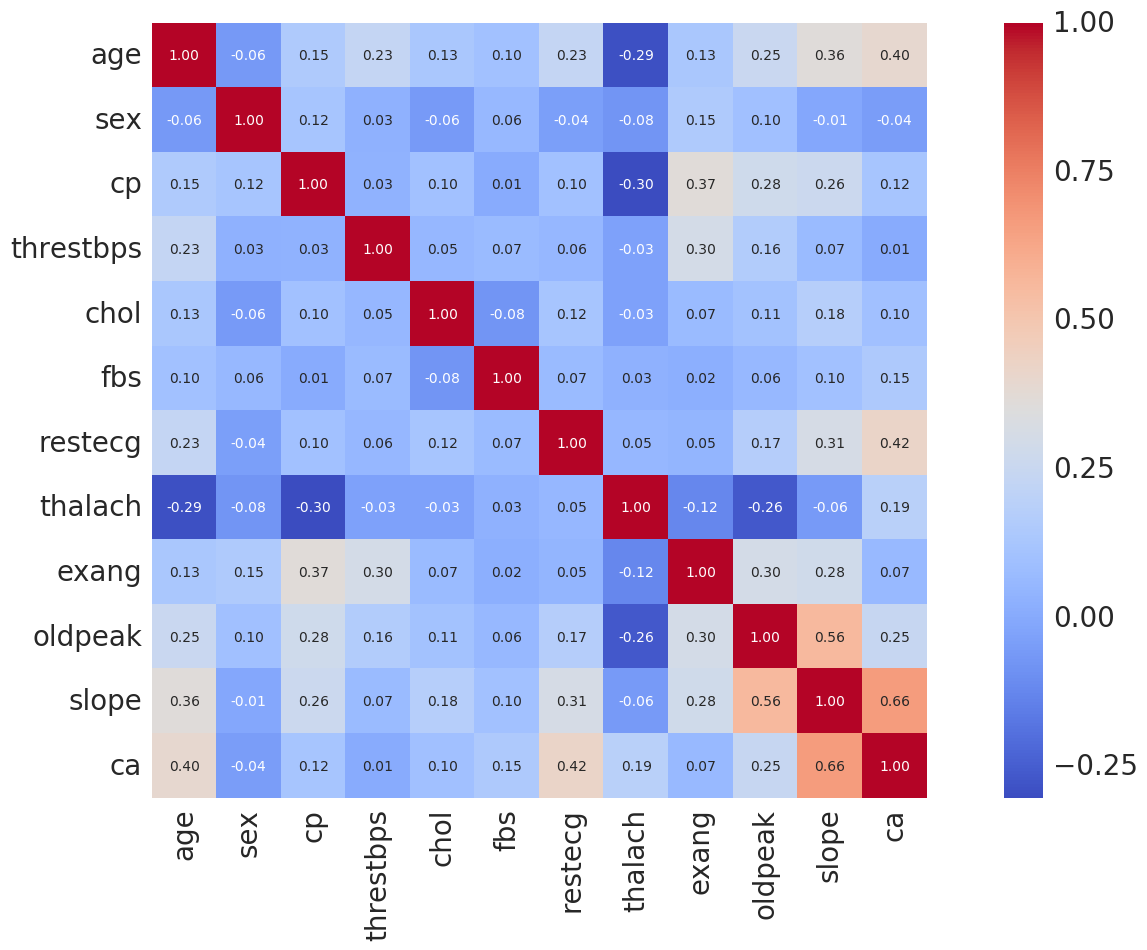

In [16]:
# Check for Correlation among our 14 Attributes

import seaborn as sns
import matplotlib.pyplot as plt

# prediction variables
prediction_variables = ['age', 'sex', 'cp', 'threstbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak',
                            'slope', 'ca', 'thal']



data = split_all_data(prediction_variables)
train_x = data[0]
train_y = data[1]
test_x = data[2]
test_y = data[3]
cross_validation_data = data[4]
all_data = data[4]

def find_best_prediction_variables(data):
    # variables that are used to predict are in columns 0 - 12
    pred_variables = list(data.columns[0:12])
    # find correlation between all prediction variables
    corr = data[pred_variables].corr()
    # plot figure
    plt.figure(figsize=(20 , 10))
    # map features
    sns.set(font_scale=2)
    sns.heatmap(corr, cbar=True, square=True, annot=True, fmt='.2f', annot_kws={'size': 10}, xticklabels=pred_variables,
                yticklabels=pred_variables, cmap='coolwarm')
    plt.show()
    
find_best_prediction_variables(all_data)

# From the Heatmap below, seems like No columns have the same set of colors
# Therefore, No columns are correlated

In [17]:
# Implement Grid Search CV to find best Params
# For Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time
start = time.time()

model = RandomForestClassifier()
parameters_grid = [
        {
            'n_estimators': [10, 50, 100, 150, 200],
            'criterion' : ['gini' , 'entropy'],
            'max_features' : ['auto' , 'sqrt' , 'log2'],
            'max_depth': [5, 10, 15, 40],
            'min_samples_leaf': [1, 2, 3, 4, 5]

        }
    ]
clf = GridSearchCV(model, parameters_grid, cv=5, scoring="accuracy", n_jobs=7)
clf.fit(train_x, train_y)

print("Best Parameters: ")
print(clf.best_params_)

end = time.time()
print("----Time s taken on GCP w/52GB RAM and 8vCPUs/Intel Ivy Bridge---")
print(end - start)


Best Parameters: 
{'max_depth': 5, 'criterion': 'entropy', 'min_samples_leaf': 3, 'n_estimators': 10, 'max_features': 'log2'}
----Time s taken on GCP w/52GB RAM and 8vCPUs/Intel Ivy Bridge---
119.3082218170166


In [18]:
# Cross Validate Models to Prevent overfitting
# Cross-validation is a model validation 
# technique for assessing how the results of a statistical analysis will generalize to an independent data set.
# https://en.wikipedia.org/wiki/Cross-validation_(statistics)

from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

def classification_model(model, data, prediction_input, output):
    # fit using entire dataset
    model.fit(data[prediction_input], data[output])
    # predict based on entire dataset
    predictions = model.predict(data[prediction_input])
    # accuracy
    accuracy = accuracy_score(predictions, data[output])
    print ("Accuracy: ", accuracy)

    # create 5 partitions
    kf = KFold(n_splits=5)

    error = []

    # Split dataset into 5 consecutive folds
    for train, test in kf.split(data):
        # rows & columns
        train_X = (data[prediction_input].iloc[train,:])
        # rows
        train_y = data[output].iloc[train]
        model.fit(train_X, train_y)

        # test data also
        test_X = data[prediction_input].iloc[test, :]
        test_y = data[output].iloc[test]
        error.append(model.score(test_X, test_y))

        # score
        print("Cross Validation score: ", np.mean(error))


In [19]:
# Test our model using Crossvalidation and use best Parameters
test_model = RandomForestClassifier(**clf.best_params_)
outcome_var = "num"
classification_model(model, cross_validation_data, prediction_variables, outcome_var)


Accuracy:  0.993243243243
Cross Validation score:  0.63025210084
Cross Validation score:  0.588235294118
Cross Validation score:  0.589896975739
Cross Validation score:  0.605558325025
Cross Validation score:  0.625124626122


In [20]:
# Persist Model on Disk
import pickle

persisted_model = RandomForestClassifier(**clf.best_params_)
persisted_model.fit(train_x, train_y)

saved = pickle.dumps(persisted_model)

read_persisted_model = pickle.loads(saved)
pred = read_persisted_model.predict(test_x)
print('Accuracy Score: ', accuracy_score(pred, test_y))

Accuracy Score:  0.657303370787


In [21]:
# Predict a random sample
# Using the saved model
saved_model = pickle.loads(saved)
pred_val = saved_model.predict([[60.0,1.0,4.0,130.0,206.0,6.0,2.0,290.0,1.0,2.4,2.0,2.0,10.0]])
print('Predicted Val: ', pred_val )

Predicted Val:  [2]
